### Libraries

In [35]:
from typing import Tuple, List
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import os
import time
from numba import njit, prange

# Preparing the Dataset

## Setting directory

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Ml_scale/ml-32m

/content/gdrive/MyDrive/Colab Notebooks/Ml_scale/ml-32m


## Content Verfication

In [5]:
!md5sum links.csv movies.csv ratings.csv tags.csv

8f033867bcb4e6be8792b21468b4fa6e  links.csv
0df90835c19151f9d819d0822e190797  movies.csv
cf12b74f9ad4b94a011f079e26d4270a  ratings.csv
963bf4fa4de6b8901868fddd3eb54567  tags.csv


# Optimization

In [6]:

# ============================================================================
# NUMBA KERNELS (The Engine Room)
# These functions handle the heavy math logic exactly as you wrote it,
# but compiled to machine code and parallelized.
# ============================================================================

@njit(parallel=True, fastmath=True)
def _numba_compute_loss(user_ptr, col_indices, values, U, V, b_u, b_m,
                        lamda, gamma_u, gamma_v, gamma_b):
    """
    Numba optimized loss computation.
    """
    squared_error = 0.0
    n_ratings = 0
    n_users = len(user_ptr) - 1

    # Parallel loop over users
    for u in prange(n_users):
        start = user_ptr[u]
        end = user_ptr[u+1]

        if start == end:
            continue

        # Slice for this user
        cols = col_indices[start:end]
        ratings = values[start:end]

        # Calculate error for this user's ratings
        local_error = 0.0
        for i in range(len(cols)):
            m = cols[i]
            r = ratings[i]

            # Dot product U[:, u] @ V[:, m]
            interaction = 0.0
            for f in range(U.shape[0]):
                interaction += U[f, u] * V[f, m]

            pred = interaction + b_u[u] + b_m[m]
            diff = r - pred
            local_error += diff * diff

        squared_error += local_error
        n_ratings += (end - start)

    # Regularization (Global sums)
    user_embedding_reg = np.sum(U ** 2)
    movie_embedding_reg = np.sum(V ** 2)
    user_bias_reg = np.sum(b_u ** 2)
    movie_bias_reg = np.sum(b_m ** 2)

    loss = (lamda / 2) * squared_error + \
           (gamma_u / 2) * user_embedding_reg + \
           (gamma_v / 2) * movie_embedding_reg + \
           (gamma_b / 2) * (user_bias_reg + movie_bias_reg)

    rmse = np.sqrt(squared_error / n_ratings) if n_ratings > 0 else 0.0

    return loss, rmse

@njit(parallel=True, fastmath=True)
def _numba_update_users(user_ptr, col_indices, values, U, V, b_u, b_m,
                        k, lamda, gamma_u, gamma_b):
    """
    Numba optimized User Update loop.
    """
    n_users = len(user_ptr) - 1

    # Iterate over users in parallel
    for u in prange(n_users):
        start = user_ptr[u]
        end = user_ptr[u+1]

        if start == end:
            continue

        n_ratings = end - start
        cols = col_indices[start:end]  # Movie indices
        ratings = values[start:end]    # Rating values

        # 1. BIAS UPDATE
        # ---------------------------------------------------------
        # Calculate residuals: r - b_m - interaction
        sum_residuals = 0.0

        # We need to construct the interaction term to get residual
        # We can compute this efficiently without full matrix ops
        for i in range(n_ratings):
            m_idx = cols[i]
            r_val = ratings[i]

            dot_val = 0.0
            for f in range(k):
                dot_val += U[f, u] * V[f, m_idx]

            sum_residuals += (r_val - b_m[m_idx] - dot_val)

        bias = lamda * sum_residuals
        b_u[u] = bias / (lamda * n_ratings + gamma_b)

        # 2. EMBEDDING UPDATE
        # ---------------------------------------------------------
        # We need to solve (gamma_u * I + lamda * V @ V.T) * x = lamda * V @ (r - b_u - b_m)

        # Init A (LHS) with Identity * gamma_u
        A = np.eye(k, dtype=np.float64) * gamma_u
        # Init B (RHS)
        B = np.zeros(k, dtype=np.float64)

        # Accumulate V @ V.T and V @ residuals
        for i in range(n_ratings):
            m_idx = cols[i]
            r_val = ratings[i]

            # Pre-fetch V column for this movie
            # (Optimization: accessing V[:, m_idx] repeatedly is fine)

            # Update A: A += lamda * outer(v, v)
            # Manually unrolled outer product addition for speed
            factor = lamda
            for r in range(k):
                val_r = V[r, m_idx]
                # Update B here too: B += lamda * v * residual
                # Note: residual changes because b_u changed above
                residual = r_val - b_u[u] - b_m[m_idx]
                B[r] += factor * val_r * residual

                for c in range(k):
                    A[r, c] += factor * val_r * V[c, m_idx]

        # Solve Ax = B
        # np.linalg.solve is supported in Numba
        # Since we added gamma_u * I, matrix is positive definite (invertible)
        U[:, u] = np.linalg.solve(A, B)


@njit(parallel=True, fastmath=True)
def _numba_update_movies(movie_ptr, row_indices, values, U, V, b_u, b_m,
                         k, lamda, gamma_v, gamma_b):
    """
    Numba optimized Movie Update loop.
    """
    n_movies = len(movie_ptr) - 1

    for m in prange(n_movies):
        start = movie_ptr[m]
        end = movie_ptr[m+1]

        if start == end:
            continue

        n_ratings = end - start
        rows = row_indices[start:end] # User indices
        ratings = values[start:end]   # Rating values

        # 1. BIAS UPDATE
        sum_residuals = 0.0

        for i in range(n_ratings):
            u_idx = rows[i]
            r_val = ratings[i]

            dot_val = 0.0
            for f in range(k):
                dot_val += U[f, u_idx] * V[f, m]

            sum_residuals += (r_val - b_u[u_idx] - dot_val)

        bias = lamda * sum_residuals
        b_m[m] = bias / (lamda * n_ratings + gamma_b)

        # 2. EMBEDDING UPDATE
        A = np.eye(k, dtype=np.float64) * gamma_v
        B = np.zeros(k, dtype=np.float64)

        factor = lamda
        for i in range(n_ratings):
            u_idx = rows[i]
            r_val = ratings[i]

            # Residual uses updated movie bias
            residual = r_val - b_u[u_idx] - b_m[m]

            for r in range(k):
                val_r = U[r, u_idx]
                B[r] += factor * val_r * residual
                for c in range(k):
                    A[r, c] += factor * val_r * U[c, u_idx]

        V[:, m] = np.linalg.solve(A, B)




In [7]:

# ============================================================================
# CLASS DEFINITION
# ============================================================================

class SparseMatrix:
    """
    Sparse matrix in CSR (Compressed Sparse Row) format for efficient user-based iteration.
    Also maintains CSC (Compressed Sparse Column) format for movie-based iteration.
    """

    def __init__(self, ratings):
        self.number_of_users = 0
        self.userid_to_idx = {}
        self.idx_to_userid = []

        self.number_of_movies = 0
        self.movieid_to_idx = {}
        self.idx_to_movieid = []

        # Temporary storage during construction
        data_by_user = []
        data_by_movie = []

        for rating in ratings:
            # Map user IDs to indices
            if rating[0] not in self.userid_to_idx:
                self.idx_to_userid.append(rating[0])
                self.userid_to_idx[rating[0]] = self.number_of_users
                self.number_of_users += 1
                data_by_user.append([])

            # Map movie IDs to indices
            if rating[1] not in self.movieid_to_idx:
                self.idx_to_movieid.append(rating[1])
                self.movieid_to_idx[rating[1]] = self.number_of_movies
                self.number_of_movies += 1
                data_by_movie.append([])

            user_idx = self.userid_to_idx[rating[0]]
            movie_idx = self.movieid_to_idx[rating[1]]
            rating_val = rating[2].item() if hasattr(rating[2], 'item') else rating[2]

            data_by_user[user_idx].append((movie_idx, rating_val))
            data_by_movie[movie_idx].append((user_idx, rating_val))

        # Build CSR format (for users)
        self._build_csr(data_by_user)

        # Build CSC format (for movies)
        self._build_csc(data_by_movie)

        print(f"Initialized SparseMatrix:")
        print(f"  Users: {self.number_of_users}")
        print(f"  Movies: {self.number_of_movies}")
        print(f"  Ratings: {len(self.csr_col_indices)}")


    def _build_csr(self, data_by_user):
        """Build CSR (Compressed Sparse Row) format for user-based access"""
        self.user_ptr = np.zeros(self.number_of_users + 1, dtype=np.int32)
        all_movie_indices = []
        all_ratings = []

        for user_idx, user_ratings in enumerate(data_by_user):
            all_movie_indices.extend([movie_idx for movie_idx, rating in user_ratings])
            all_ratings.extend([rating for movie_idx, rating in user_ratings])
            self.user_ptr[user_idx + 1] = len(all_movie_indices)

        self.csr_col_indices = np.array(all_movie_indices, dtype=np.int32)
        self.csr_values = np.array(all_ratings, dtype=np.float32)


    def _build_csc(self, data_by_movie):
        """Build CSC (Compressed Sparse Column) format for movie-based access"""
        self.movie_ptr = np.zeros(self.number_of_movies + 1, dtype=np.int32)
        all_user_indices = []
        all_ratings = []

        for movie_idx, movie_ratings in enumerate(data_by_movie):
            all_user_indices.extend([user_idx for user_idx, rating in movie_ratings])
            all_ratings.extend([rating for user_idx, rating in movie_ratings])
            self.movie_ptr[movie_idx + 1] = len(all_user_indices)

        self.csc_row_indices = np.array(all_user_indices, dtype=np.int32)
        self.csc_values = np.array(all_ratings, dtype=np.float32)


    def split(self, split_ratio):
        """
        Split data into train/test sets.
        Randomly assigns each rating to train or test, then rebuilds CSR/CSC structures.
        """
        n_ratings = len(self.csr_values)

        # Random train/test assignment
        random_vals = np.random.random(n_ratings)
        train_mask = random_vals < split_ratio
        test_mask = ~train_mask

        # Split CSR data
        data_by_user_train = [[] for _ in range(self.number_of_users)]
        data_by_user_test = [[] for _ in range(self.number_of_users)]

        for user_idx in range(self.number_of_users):
            start = self.user_ptr[user_idx]
            end = self.user_ptr[user_idx + 1]

            for i in range(start, end):
                movie_idx = self.csr_col_indices[i]
                rating = self.csr_values[i]

                if train_mask[i]:
                    data_by_user_train[user_idx].append((movie_idx, rating))
                else:
                    data_by_user_test[user_idx].append((movie_idx, rating))

        # Build train CSR
        self.user_ptr_train = np.zeros(self.number_of_users + 1, dtype=np.int32)
        train_movies = []
        train_ratings = []

        for user_idx, user_ratings in enumerate(data_by_user_train):
            train_movies.extend([m for m, r in user_ratings])
            train_ratings.extend([r for m, r in user_ratings])
            self.user_ptr_train[user_idx + 1] = len(train_movies)

        self.csr_col_indices_train = np.array(train_movies, dtype=np.int32)
        self.csr_values_train = np.array(train_ratings, dtype=np.float32)

        # Build test CSR
        self.user_ptr_test = np.zeros(self.number_of_users + 1, dtype=np.int32)
        test_movies = []
        test_ratings = []

        for user_idx, user_ratings in enumerate(data_by_user_test):
            test_movies.extend([m for m, r in user_ratings])
            test_ratings.extend([r for m, r in user_ratings])
            self.user_ptr_test[user_idx + 1] = len(test_movies)

        self.csr_col_indices_test = np.array(test_movies, dtype=np.int32)
        self.csr_values_test = np.array(test_ratings, dtype=np.float32)

        # Build train/test CSC (for movie iterations)
        data_by_movie_train = [[] for _ in range(self.number_of_movies)]
        data_by_movie_test = [[] for _ in range(self.number_of_movies)]

        for user_idx in range(self.number_of_users):
            for movie_idx, rating in data_by_user_train[user_idx]:
                data_by_movie_train[movie_idx].append((user_idx, rating))
            for movie_idx, rating in data_by_user_test[user_idx]:
                data_by_movie_test[movie_idx].append((user_idx, rating))

        # Build train CSC
        self.movie_ptr_train = np.zeros(self.number_of_movies + 1, dtype=np.int32)
        train_users = []
        train_ratings_csc = []

        for movie_idx, movie_ratings in enumerate(data_by_movie_train):
            train_users.extend([u for u, r in movie_ratings])
            train_ratings_csc.extend([r for u, r in movie_ratings])
            self.movie_ptr_train[movie_idx + 1] = len(train_users)

        self.csc_row_indices_train = np.array(train_users, dtype=np.int32)
        self.csc_values_train = np.array(train_ratings_csc, dtype=np.float32)

        # Build test CSC
        self.movie_ptr_test = np.zeros(self.number_of_movies + 1, dtype=np.int32)
        test_users = []
        test_ratings_csc = []

        for movie_idx, movie_ratings in enumerate(data_by_movie_test):
            test_users.extend([u for u, r in movie_ratings])
            test_ratings_csc.extend([r for u, r in movie_ratings])
            self.movie_ptr_test[movie_idx + 1] = len(test_users)

        self.csc_row_indices_test = np.array(test_users, dtype=np.int32)
        self.csc_values_test = np.array(test_ratings_csc, dtype=np.float32)

        # Store counts
        self.number_of_users_train = self.number_of_users
        self.number_of_movies_train = self.number_of_movies
        self.number_of_users_test = self.number_of_users
        self.number_of_movies_test = self.number_of_movies

        n_train = len(self.csr_values_train)
        n_test = len(self.csr_values_test)

        print(f"\nData split:")
        print(f"  Train ratings: {n_train} ({n_train/(n_train+n_test)*100:.2f}%)")
        print(f"  Test ratings: {n_test} ({n_test/(n_train+n_test)*100:.2f}%)")






def plot_training_results(loss_history, rmse_history, rmse_test_history):
    """Plot training metrics"""
    plt.figure(figsize=(18, 5))

    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(loss_history, marker='o')
    plt.title("Loss over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)

    # Plot training RMSE
    plt.subplot(1, 3, 2)
    plt.plot(rmse_history, marker='o', color='orange')
    plt.title("Training RMSE")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)

    # Plot test RMSE
    plt.subplot(1, 3, 3)
    plt.plot(rmse_test_history, marker='o', color='green')
    plt.title("Test RMSE")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



In [10]:
# ============================================================================
# Query methods (Unchanged)
# ============================================================================

def get_user_ratings(self, userid):
    if userid not in self.userid_to_idx:
        return 0, []
    user_idx = self.userid_to_idx[userid]
    start = self.user_ptr[user_idx]
    end = self.user_ptr[user_idx + 1]
    movie_indices = self.csr_col_indices[start:end]
    ratings = self.csr_values[start:end]
    user_ratings = [(self.idx_to_movieid[m], float(r)) for m, r in zip(movie_indices, ratings)]
    return len(user_ratings), user_ratings

def get_movie_ratings(self, movieid):
    if movieid not in self.movieid_to_idx:
        return 0, []
    movie_idx = self.movieid_to_idx[movieid]
    start = self.movie_ptr[movie_idx]
    end = self.movie_ptr[movie_idx + 1]
    user_indices = self.csc_row_indices[start:end]
    ratings = self.csc_values[start:end]
    movie_ratings = [(self.idx_to_userid[u], float(r)) for u, r in zip(user_indices, ratings)]
    return len(movie_ratings), movie_ratings

def get_ratings(self, userid, movieid):
    if userid not in self.userid_to_idx or movieid not in self.movieid_to_idx:
        return 0
    user_idx = self.userid_to_idx[userid]
    movie_idx = self.movieid_to_idx[movieid]
    start = self.user_ptr[user_idx]
    end = self.user_ptr[user_idx + 1]
    movies = self.csr_col_indices[start:end]
    ratings = self.csr_values[start:end]
    idx = np.where(movies == movie_idx)[0]
    if len(idx) > 0:
        return float(ratings[idx[0]])
    return 0


In [11]:

# ============================================================================
# TRAINING FUNCTIONS (Wrapped for Numba)
# ============================================================================

def compute_loss(ratings_matrix, U, V, b_u, b_m, lamda, gamma_u, gamma_v, gamma_b, train=True):
    """
    Wrapper calling the Numba optimized loss function.
    """
    if train:
        user_ptr = ratings_matrix.user_ptr_train
        col_indices = ratings_matrix.csr_col_indices_train
        values = ratings_matrix.csr_values_train
    else:
        user_ptr = ratings_matrix.user_ptr_test
        col_indices = ratings_matrix.csr_col_indices_test
        values = ratings_matrix.csr_values_test

    return _numba_compute_loss(
        user_ptr, col_indices, values,
        U, V, b_u, b_m,
        lamda, gamma_u, gamma_v, gamma_b
    )


def train_als(ratings_matrix, k=30, lamda=0.001, gamma_u=0.05, gamma_v=0.05,
              gamma_b=0.001, iterations=10):
    """
    Optimized ALS training.
    Outer loop: Python (controls flow).
    Inner loops: Numba (controls math/iteration).
    """

    print("Initializing Parameters...")
    # Initialize parameters (using float64 for stability in solver)
    user_biases = np.zeros(ratings_matrix.number_of_users, dtype=np.float64)
    movie_biases = np.zeros(ratings_matrix.number_of_movies, dtype=np.float64)

    # Scaled initialization usually helps convergence
    user_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_users)).astype(np.float64)
    movie_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_movies)).astype(np.float64)

    # For plotting
    loss_history = []
    rmse_history = []
    rmse_test_history = []

    # Pre-fetch arrays to pass to Numba (Avoid object attribute access inside loops)
    # User/CSR data
    user_ptr = ratings_matrix.user_ptr_train
    csr_cols = ratings_matrix.csr_col_indices_train
    csr_vals = ratings_matrix.csr_values_train

    # Movie/CSC data
    movie_ptr = ratings_matrix.movie_ptr_train
    csc_rows = ratings_matrix.csc_row_indices_train
    csc_vals = ratings_matrix.csc_values_train

    print(f"Starting {iterations} iterations of ALS (Numba Optimized)...")
    start_total = time.time()

    for iteration in range(iterations):
        iter_start = time.time()

        # 1. Update Users (Parallel Numba)
        _numba_update_users(
            user_ptr, csr_cols, csr_vals,
            user_embeddings, movie_embeddings, user_biases, movie_biases,
            k, lamda, gamma_u, gamma_b
        )

        # 2. Update Movies (Parallel Numba)
        _numba_update_movies(
            movie_ptr, csc_rows, csc_vals,
            user_embeddings, movie_embeddings, user_biases, movie_biases,
            k, lamda, gamma_v, gamma_b
        )

        # 3. Compute Loss (Parallel Numba)
        loss_train, rmse_train = compute_loss(
            ratings_matrix, user_embeddings, movie_embeddings,
            user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=True
        )

        loss_test, rmse_test = compute_loss(
            ratings_matrix, user_embeddings, movie_embeddings,
            user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=False
        )

        iter_time = time.time() - iter_start
        print(f"Iteration {iteration+1}/{iterations} [{iter_time:.2f}s]:\n "
              f"Train RMSE = {rmse_train:.4f}, Train Loss = {loss_train:.4f} \n "
              f"Test  RMSE = {rmse_test:.4f}, Test  Loss = {loss_test:.4f}\n")

        loss_history.append(loss_train)
        rmse_history.append(rmse_train)
        rmse_test_history.append(rmse_test)

    total_time = time.time() - start_total

    # Print summary statistics
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total Training Time: {total_time:.2f}s")
    print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
    print(f"Final Test RMSE:  {rmse_test_history[-1]:.4f}")
    print(f"Train Improvement: {((rmse_history[0] - rmse_history[-1])/rmse_history[0]*100):.2f}%")
    print(f"Test Improvement:  {((rmse_test_history[0] - rmse_test_history[-1])/rmse_test_history[0]*100):.2f}%")
    print(f"Generalization Gap: {(rmse_test_history[-1] - rmse_history[-1]):.4f}")
    print("="*60)

    return user_embeddings, movie_embeddings, user_biases, movie_biases, loss_history, rmse_history, rmse_test_history

In [14]:
def plot_training_results(loss_history, rmse_history, rmse_test_history):
    """Plot training metrics"""

    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, marker='o')
    plt.title("Loss over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.savefig('numba_plots_pdf/loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    plt.figure(figsize=(15, 5))
    # Plot training RMSE
    plt.subplot(1, 2, 1)
    plt.plot(rmse_history, marker='o', color='orange')
    plt.title("Training RMSE")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)

    # Plot test RMSE
    plt.subplot(1, 2, 2)
    plt.plot(rmse_test_history, marker='o', color='green')
    plt.title("Test RMSE")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)
    plt.savefig('numba_plots_pdf/rmse.pdf', format='pdf', dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()
    plt.close()

Initialized SparseMatrix:
  Users: 200948
  Movies: 84432
  Ratings: 32000204

Data split:
  Train ratings: 28801061 (90.00%)
  Test ratings: 3199143 (10.00%)
Initializing Parameters...
Starting 50 iterations of ALS (Numba Optimized)...
Iteration 1/50 [36.18s]:
 Train RMSE = 1.0285, Train Loss = 48131.9891 
 Test  RMSE = 1.1008, Test  Loss = 34838.1927

Iteration 2/50 [26.86s]:
 Train RMSE = 0.7518, Train Loss = 24488.3070 
 Test  RMSE = 0.8329, Test  Loss = 17459.0499

Iteration 3/50 [26.09s]:
 Train RMSE = 0.7148, Train Loss = 16438.6904 
 Test  RMSE = 0.8030, Test  Loss = 10113.2883

Iteration 4/50 [26.45s]:
 Train RMSE = 0.7030, Train Loss = 13600.4736 
 Test  RMSE = 0.7948, Test  Loss = 7493.3688

Iteration 5/50 [28.07s]:
 Train RMSE = 0.6973, Train Loss = 12216.9285 
 Test  RMSE = 0.7909, Test  Loss = 6215.3601

Iteration 6/50 [27.86s]:
 Train RMSE = 0.6940, Train Loss = 11420.2945 
 Test  RMSE = 0.7887, Test  Loss = 5479.4377

Iteration 7/50 [26.91s]:
 Train RMSE = 0.6919, Train

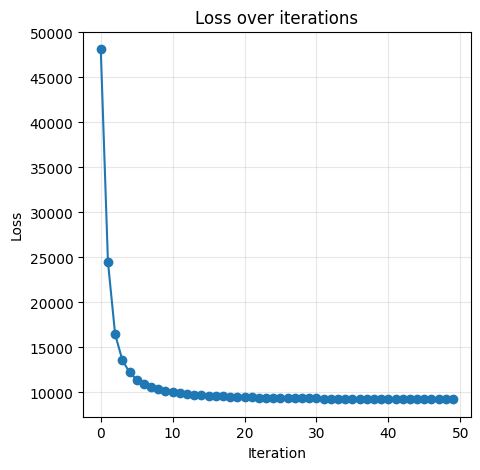

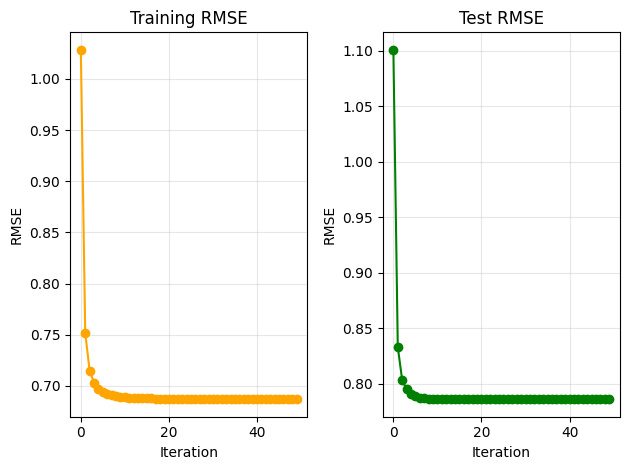

In [13]:

# ============================================================================
# EXECUTION BLOCK
# ============================================================================
if __name__ == "__main__":
    # Load data (Assuming ratings.csv exists in directory as per original code)
    try:
        # Using 'float' explicitly ensures compatibility
        ratings = np.loadtxt("ratings.csv", delimiter=",", skiprows=1, usecols=(0, 1, 2))

        # Create sparse matrix
        ratings_matrix = SparseMatrix(ratings)

        # Split data
        ratings_matrix.split(0.9)

        # Hyperparameters
        k = 20
        lamda = 0.001
        gamma_u = 0.01
        gamma_v = 0.01
        gamma_b = 0.1
        iterations = 50

        # Train
        user_embeddings, movie_embeddings, user_biases, movie_biases, \
            loss_history, rmse_history, rmse_test_history = train_als(
                ratings_matrix, k=k, lamda=lamda, gamma_u=gamma_u, gamma_v=gamma_v,
                gamma_b=gamma_b, iterations=iterations
            )

        # Plot
        plot_training_results(loss_history, rmse_history, rmse_test_history)

    except OSError:
        print("Error: 'ratings.csv' not found. Please ensure the file is in the working directory.")

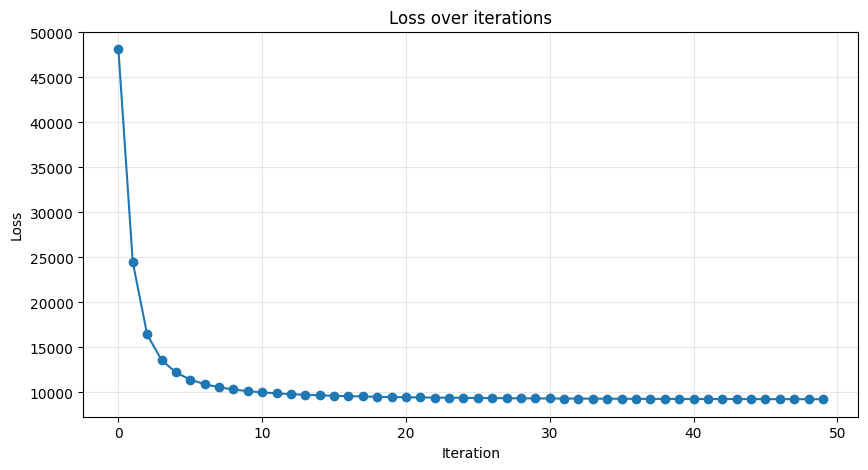

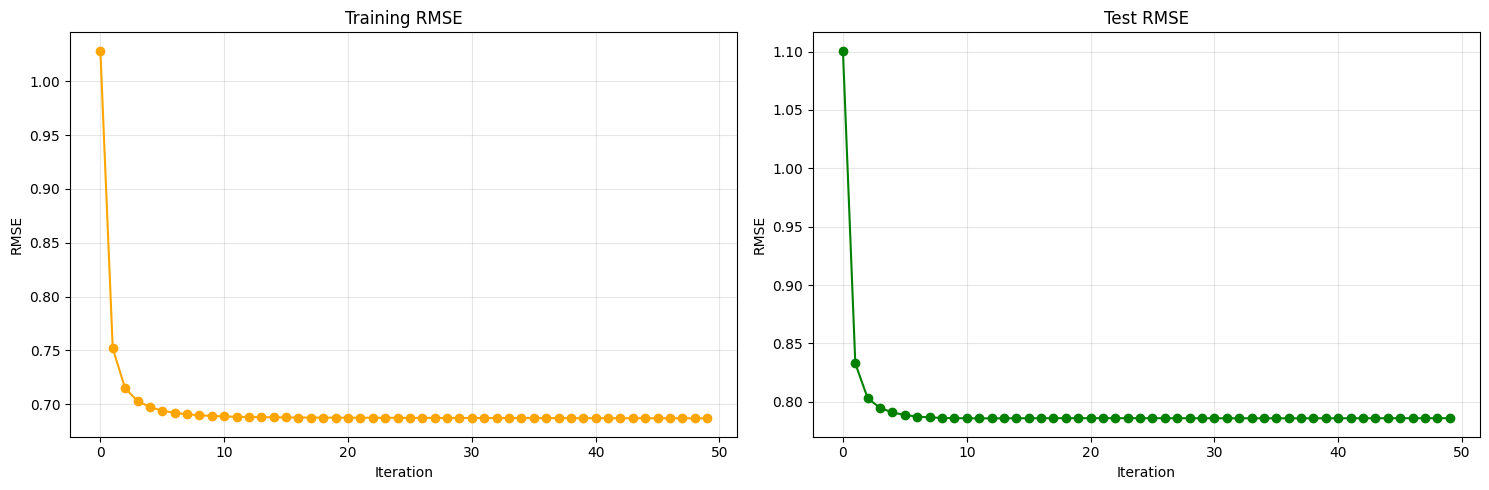

In [15]:
plot_training_results(loss_history, rmse_history, rmse_test_history)


# Testing Recommendation for a Dummy User

In [16]:
# Load movies metadata
try:
    df2 = pd.read_csv('movies.csv')
except FileNotFoundError:
    print("Warning: 'movies.csv' not found. Creating dummy dataframe.")
    df2 = pd.DataFrame({'movieId': range(10000), 'title': ['Movie']*10000, 'genres': ['Drama']*10000})

In [17]:

# ============================================================================
# NUMBA KERNELS (FIXED)
# ============================================================================

@njit(fastmath=True)
def _numba_dummy_train_kernel(movie_indices, rating_values, V, b_m,
                              lamda, gamma_u, gamma_b, k, iterations):
    """
    Numba kernel to train a single user vector.
    FIX: Replaced try-except with direct np.linalg.lstsq for stability.
    """
    # Initialize random embedding
    dummy_user_embedding = np.random.normal(0, 0.1, size=(k,)).astype(np.float64)
    dummy_bias = 0.0
    n_ratings = len(movie_indices)

    # Pre-allocate identity matrix scaled by gamma_u
    eye_k = np.eye(k, dtype=np.float64) * gamma_u

    for _ in range(iterations):
        # 1. Update Bias
        bias_sum = 0.0
        for i in range(n_ratings):
            m_idx = movie_indices[i]
            r = rating_values[i]

            # Dot product: dummy_emb @ V[:, m_idx]
            dot_val = 0.0
            for f in range(k):
                dot_val += dummy_user_embedding[f] * V[f, m_idx]

            pred = b_m[m_idx] + dot_val
            bias_sum += lamda * (r - pred)

        dummy_bias = bias_sum / (lamda * n_ratings + gamma_b)

        # 2. Update Embedding
        first_term = eye_k.copy()
        second_term = np.zeros(k, dtype=np.float64)

        for i in range(n_ratings):
            m_idx = movie_indices[i]
            r = rating_values[i]

            # Update second term: v_n * (rating - bias - b_m)
            residual = r - dummy_bias - b_m[m_idx]

            # Manual outer product accumulation for speed
            factor = lamda
            for r_idx in range(k):
                v_r = V[r_idx, m_idx]
                second_term[r_idx] += factor * v_r * residual

                for c_idx in range(k):
                    first_term[r_idx, c_idx] += factor * v_r * V[c_idx, m_idx]

        # FIX: Use lstsq directly. It handles both singular and non-singular matrices.
        # rcond=-1 tells LAPACK to use machine precision default
        dummy_user_embedding = np.linalg.lstsq(first_term, second_term, rcond=-1)[0]

    return dummy_user_embedding, dummy_bias


@njit(parallel=True, fastmath=True)
def _numba_calculate_scores(dummy_emb, V, dummy_bias, b_m, movie_ptr):
    """
    Calculates scores for all movies in parallel.
    """
    n_movies = V.shape[1]
    k = V.shape[0]
    scores = np.zeros(n_movies, dtype=np.float64)

    for m in prange(n_movies):
        # Check rating count using the pointer structure
        count = movie_ptr[m+1] - movie_ptr[m]

        if count < 100:
            scores[m] = 0.0
        else:
            # Dot product
            dot_val = 0.0
            for f in range(k):
                dot_val += dummy_emb[f] * V[f, m]

            scores[m] = dot_val + (b_m[m] * 0.05)

    return scores


@njit(parallel=True, fastmath=True)
def _numba_calc_norms(V):
    """Calculate L2 norm of every movie column"""
    n_movies = V.shape[1]
    norms = np.zeros(n_movies, dtype=np.float64)
    for m in prange(n_movies):
        col_sum = 0.0
        for f in range(V.shape[0]):
            val = V[f, m]
            col_sum += val * val
        norms[m] = np.sqrt(col_sum)
    return norms



In [18]:
# ============================================================================
# WRAPPER FUNCTIONS
# ============================================================================

def dummy_user_train(dummy_user_ratings, movie_embeddings, movie_biases, lamda, gamma_u, gamma_b, k=10, iterations=10):
    if len(dummy_user_ratings) == 0:
        return np.zeros(k), 0.0

    # Convert inputs to Numba-friendly arrays
    indices = np.array([x[0] for x in dummy_user_ratings], dtype=np.int32)
    values = np.array([x[1] for x in dummy_user_ratings], dtype=np.float64)

    return _numba_dummy_train_kernel(
        indices, values, movie_embeddings, movie_biases,
        lamda, gamma_u, gamma_b, k, iterations
    )

def dummy_user_recommendation(dummy_user_embedding, movie_embeddings, dummy_bias, movie_biases):
    # Use movie_ptr from global 'ratings_matrix' for counts
    score = _numba_calculate_scores(
        dummy_user_embedding,
        movie_embeddings,
        dummy_bias,
        movie_biases,
        ratings_matrix.movie_ptr
    )

    ranked_items = np.argsort(score)[::-1]
    return score, ranked_items



In [21]:
# ============================================================================
# EXECUTION SCRIPT
# ============================================================================

# 1. Setup Dummy User
dummy_movie_ids = [81535]  #
dummy_ratings = [5.0]
dummy_movie_idx = []
dummy_user_ratings = []
n_rec = 15

for id, rating in zip(dummy_movie_ids, dummy_ratings):
    if id in ratings_matrix.movieid_to_idx:
        mov_idx = ratings_matrix.movieid_to_idx[id]
        dummy_movie_idx.append(mov_idx)
        dummy_user_ratings.append((mov_idx, rating))

# 2. Train (Optimized)
dummy_user_embidding, dummy_bias = dummy_user_train(
    dummy_user_ratings,
    movie_embeddings,
    movie_biases,
    lamda=lamda,
    gamma_u=gamma_u,
    gamma_b=gamma_b,
    k=k,
    iterations=iterations
)

# 3. Predict (Optimized)
score, ranked_items = dummy_user_recommendation(dummy_user_embidding, movie_embeddings, dummy_bias, movie_biases)

# 4. Filter & Display Recommendations
top_recommendations = []
for i in range(len(ranked_items)):
    if ranked_items[i] not in dummy_movie_idx:
        top_recommendations.append(ranked_items[i])
    if len(top_recommendations) >= n_rec:
        break

print("\n" + "="*60)
print("RECOMMENDATION RESULTS")
print("="*60)
for i in range(len(top_recommendations)):
    rec_idx = top_recommendations[i]
    rec_id = ratings_matrix.idx_to_movieid[rec_idx]
    try:
        row = df2[df2['movieId'] == rec_id][['title', 'genres']].values[0]
        print(f"{i+1}. {row[0]} ({row[1]})")
    except IndexError:
        print(f"{i+1}. Movie ID {rec_id} (Title Not Found)")


# ============================================================================
# DEBUGGING & ANALYSIS
# ============================================================================
print("\n" + "="*60)
print("DEBUGGING DUMMY USER")
print("="*60)

print("\nRated Movies:")
for movie_id in dummy_movie_ids:
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]} ({row[1]})")
    except:
        pass

print(f"\nDummy user embedding norm: {np.linalg.norm(dummy_user_embidding):.4f}")
print(f"Dummy user bias: {dummy_bias:.4f}")

print(f"\nScore statistics:")
print(f"  Min: {score.min():.4f}, Max: {score.max():.4f}, Mean: {score.mean():.4f}")




RECOMMENDATION RESULTS
1. Saw (2004) (Horror|Mystery|Thriller)
2. Saw II (2005) (Horror|Thriller)
3. Saw III (2006) (Crime|Horror|Thriller)
4. Saw IV (2007) (Crime|Horror|Thriller)
5. Saw V (2008) (Crime|Horror|Thriller)
6. Saw VI (2009) (Crime|Horror|Mystery|Thriller)
7. Saw (2003) (Crime|Horror)
8. Hostel (2005) (Horror)
9. Texas Chainsaw Massacre, The (2003) (Horror)
10. Final Destination (2000) (Drama|Thriller)
11. Hills Have Eyes, The (2006) (Drama|Horror|Thriller)
12. Nightmare on Elm Street, A (1984) (Horror|Thriller)
13. Texas Chainsaw Massacre: The Beginning, The (2006) (Horror|Thriller)
14. Final Destination 2 (2003) (Horror|Thriller)
15. Devil's Rejects, The (2005) (Action|Crime|Horror)

DEBUGGING DUMMY USER

Rated Movies:
Saw VII 3D - The Final Chapter (2010) (Horror|Mystery|Thriller)

Dummy user embedding norm: 0.6991
Dummy user bias: 0.0154

Score statistics:
  Min: -1.1226, Max: 4.2421, Mean: 0.1266


In [20]:
# ============================================================================
# POLARIZING MOVIES
# ============================================================================
print("\n" + "="*60)
print("POLARIZING MOVIES")
print("="*60)

n_polorizing_movies = 30
norms = _numba_calc_norms(movie_embeddings)
movies_idx_sorted_by_norm = np.argsort(norms)[::-1]
polorizing_movies_id = [ratings_matrix.idx_to_movieid[idx] for idx in movies_idx_sorted_by_norm[:n_polorizing_movies]]

for movie_id in polorizing_movies_id:
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]} ({row[1]})")
    except IndexError:
        pass


POLARIZING MOVIES
Lord of the Rings: The Return of the King, The (2003) (Action|Adventure|Drama|Fantasy)
Lord of the Rings: The Two Towers, The (2002) (Adventure|Fantasy)
Lord of the Rings: The Fellowship of the Ring, The (2001) (Adventure|Fantasy)
Natural Born Killers (1994) (Action|Crime|Thriller)
Star Wars: Episode I - The Phantom Menace (1999) (Action|Adventure|Sci-Fi)
Dumb & Dumber (Dumb and Dumber) (1994) (Adventure|Comedy)
Star Wars: Episode II - Attack of the Clones (2002) (Action|Adventure|Sci-Fi|IMAX)
Star Wars: Episode III - Revenge of the Sith (2005) (Action|Adventure|Sci-Fi)
Star Wars: Episode IV - A New Hope (1977) (Action|Adventure|Sci-Fi)
Rocky Horror Picture Show, The (1975) (Comedy|Horror|Musical|Sci-Fi)
Star Wars: Episode VI - Return of the Jedi (1983) (Action|Adventure|Sci-Fi)
Harry Potter and the Half-Blood Prince (2009) (Adventure|Fantasy|Mystery|Romance|IMAX)
Star Wars: Episode V - The Empire Strikes Back (1980) (Action|Adventure|Sci-Fi)
Harry Potter and the Dea

## Feature Vactors:

In [36]:
# ============================================================================
# NUMBA KERNELS (Standardization & PCA)
# ============================================================================
@njit(parallel=True)
def _numba_standard_scaler(data):
    n_samples, n_features = data.shape
    scaled = np.empty_like(data)

    for j in prange(n_features):
        # 1. Compute Mean/Std
        col_sum = 0.0
        col_sq_sum = 0.0
        for i in range(n_samples):
            col_sum += data[i, j]
            col_sq_sum += data[i, j]**2

        mean = col_sum / n_samples
        # Population variance (StandardScaler default)
        var = (col_sq_sum / n_samples) - (mean * mean)
        std = np.sqrt(var) if var > 0 else 1.0

        # 2. Normalize
        for i in range(n_samples):
            scaled[i, j] = (data[i, j] - mean) / std

    return scaled

@njit
def _numba_pca_2d(data):
    n_samples = data.shape[0]
    # Sample Covariance Matrix
    cov = (data.T @ data) / (n_samples - 1)

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # Sort descending
    idx = np.argsort(eig_vals)[::-1]
    components = eig_vecs[:, idx[:2]]

    return data @ components


@njit(parallel=True)
def get_movie_counts_numba(movie_ptr):
    """
    Fast calculation of rating counts per movie using the CSC pointers.
    """
    n_movies = len(movie_ptr) - 1
    counts = np.zeros(n_movies, dtype=np.int32)

    for m in prange(n_movies):
        counts[m] = movie_ptr[m+1] - movie_ptr[m]

    return counts



Running Numba Optimized PCA...
Original Data Shape: (20, 84432)
Reduced Data Shape: (84432, 2)



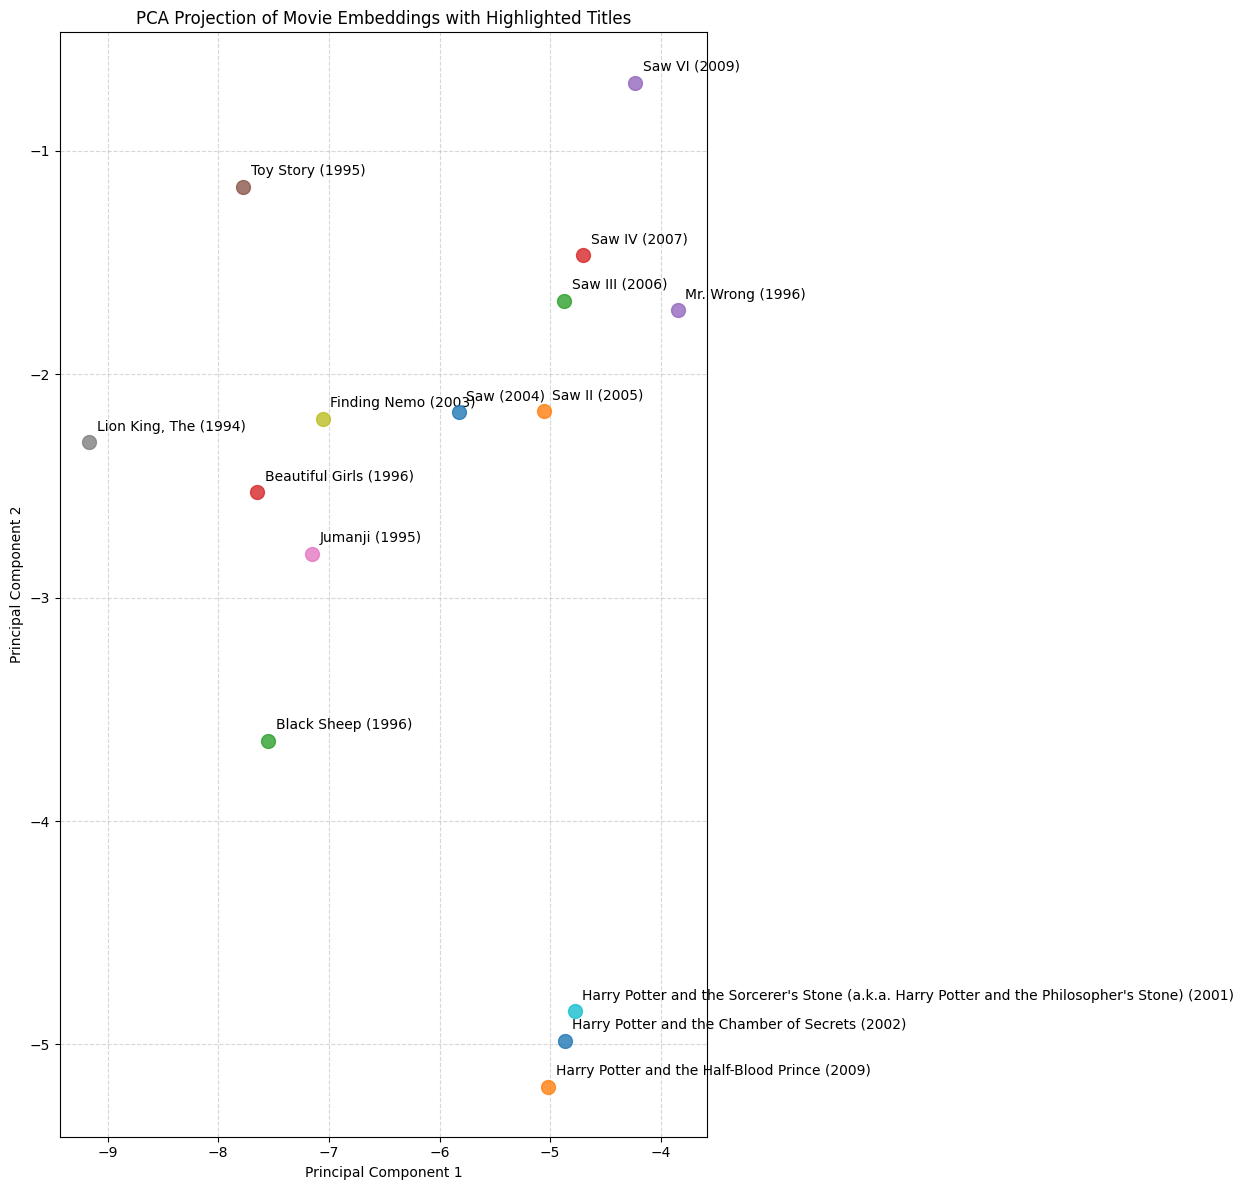

In [44]:
# ============================================================================
# EXECUTION & PLOTTING
# ============================================================================

print("Running Numba Optimized PCA...")

# 1. Transpose (Users as features, Movies as samples for the plot)
X_input = movie_embeddings.T

# 2. Standardize (Numba)
Standarized_movie_embeddings = _numba_standard_scaler(X_input)

# 3. PCA (Numba)
movie_embeddings_2D = _numba_pca_2d(Standarized_movie_embeddings)

print("Original Data Shape:", movie_embeddings.shape)
print("Reduced Data Shape:", movie_embeddings_2D.shape)
print()

# 4. Plotting (Standard Python/Matplotlib - cannot be Numba optimized)
movie_ids_plot = [8957, 39446, 48877, 55577, 72129, 1, 2, 364, 6377, 4896, 5816, 69844, 88, 94, 102]

plt.figure(figsize=(12, 12))
plt.title("PCA Projection of Movie Embeddings with Highlighted Titles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
# Adjusting limits slightly to ensure text fits; these depend on random init
# You might need to remove fixed limits if points scatter differently
# plt.xlim(-2, 8)
# plt.ylim(0, 10)
plt.grid(True, linestyle='--', alpha=0.5)

offset = 0.07

# Iterate and Plot
for movie in movie_ids_plot:
    if movie in ratings_matrix.movieid_to_idx:
        movie_idx_plot = ratings_matrix.movieid_to_idx[movie]

        movie_x = movie_embeddings_2D[movie_idx_plot, 0]
        movie_y = movie_embeddings_2D[movie_idx_plot, 1]

        plt.scatter(movie_x, movie_y, s=100, alpha=0.8, zorder=5)

        # Retrieve Title safely
        try:
            row = df2[df2['movieId'] == movie][['title']].values[0][0]
            plt.annotate(
                row,
                (movie_x, movie_y),
                xytext=(movie_x + offset, movie_y + offset),
                fontsize=10,
                textcoords='data',
                ha='left',
                va='center'
            )
        except IndexError:
            print(f"Title not found for ID {movie}")

plt.tight_layout()
plt.savefig('numba_plots_pdf/pca_movies.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

1. Sorting movies by popularity...
2. Collecting top 100 movies for: ['Children', 'Horror', 'Comedy', 'Documentary']...
   Found 100 movies for 'Children'
   Found 100 movies for 'Horror'
   Found 100 movies for 'Comedy'
   Found 100 movies for 'Documentary'
3. Running Numba PCA on shape (400, 20)...
4. Generating PCA Plot...


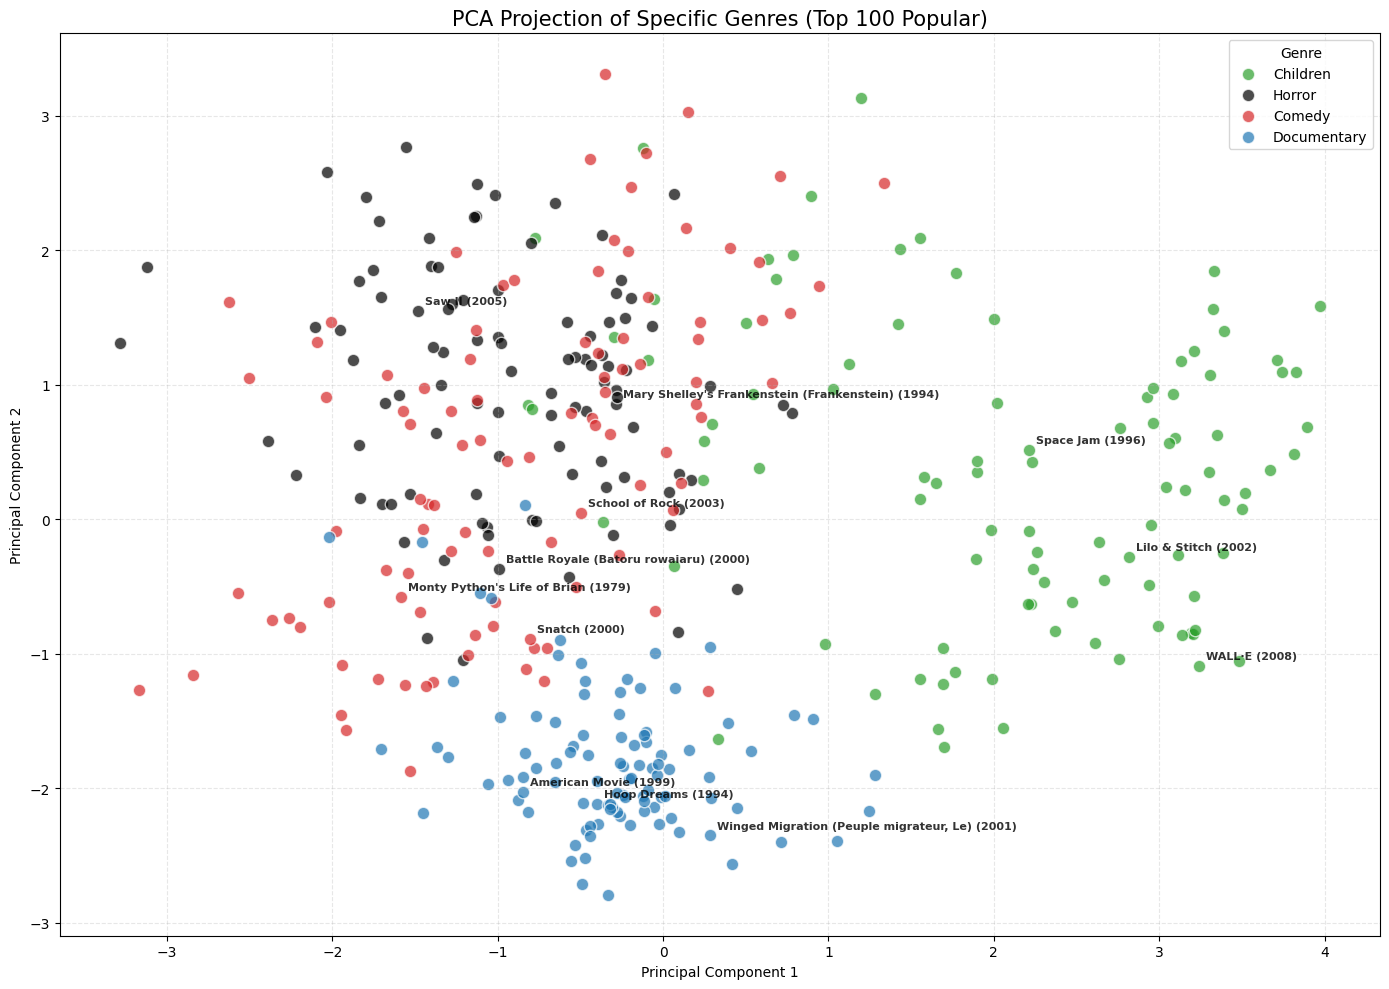

In [45]:

# ============================================================================
# 1. NUMBA KERNELS (MATH & STATS)
# ============================================================================

@njit(parallel=True)
def get_movie_counts_numba(movie_ptr):
    """Fast rating counts"""
    n_movies = len(movie_ptr) - 1
    counts = np.zeros(n_movies, dtype=np.int32)
    for m in prange(n_movies):
        counts[m] = movie_ptr[m+1] - movie_ptr[m]
    return counts

@njit(parallel=True)
def _numba_standard_scaler(data):
    """Optimized StandardScaler (Z-score normalization)"""
    n_samples, n_features = data.shape
    scaled = np.empty_like(data)

    for j in prange(n_features):
        col_sum = 0.0
        col_sq_sum = 0.0
        for i in range(n_samples):
            val = data[i, j]
            col_sum += val
            col_sq_sum += val**2

        mean = col_sum / n_samples
        var = (col_sq_sum / n_samples) - (mean * mean)
        std = np.sqrt(var) if var > 0 else 1.0

        for i in range(n_samples):
            scaled[i, j] = (data[i, j] - mean) / std

    return scaled

@njit
def _numba_pca_2d(data):
    """Optimized PCA for 2 components"""
    n_samples = data.shape[0]
    # Sample Covariance Matrix
    cov = (data.T @ data) / (n_samples - 1)

    # Eigendecomposition (returns eigenvalues in ascending order)
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # Sort descending (Top 2)
    idx = np.argsort(eig_vals)[::-1]
    components = eig_vecs[:, idx[:2]]

    # Project
    return data @ components

# ============================================================================
# 2. VISUALIZATION FUNCTION
# ============================================================================

def visualize_specific_genres_pca(ratings_matrix, movie_embeddings, df_movies,
                                  target_genres=['Children', 'Horror', 'Sci-Fi', 'Documentary'],
                                  samples_per_genre=100):

    print(f"1. Sorting movies by popularity...")
    counts = get_movie_counts_numba(ratings_matrix.movie_ptr)
    sorted_indices = np.argsort(counts)[::-1]

    print(f"2. Collecting top {samples_per_genre} movies for: {target_genres}...")

    collected_data = {genre: [] for genre in target_genres}
    seen_movies = set()

    # Filter Logic
    for idx in sorted_indices:
        if all(len(collected_data[g]) >= samples_per_genre for g in target_genres):
            break

        movie_id = ratings_matrix.idx_to_movieid[idx]
        if movie_id in seen_movies: continue

        try:
            row = df_movies[df_movies['movieId'] == movie_id].values[0]
            title = row[1]
            genre_str = row[2]

            for target in target_genres:
                if target in genre_str:
                    if len(collected_data[target]) < samples_per_genre:
                        collected_data[target].append({
                            'embedding': movie_embeddings[:, idx], # Shape (k,)
                            'title': title,
                            'genre_label': target
                        })
                        seen_movies.add(movie_id)
                        break
        except IndexError:
            continue

    # Prepare Data for PCA
    final_embeddings = []
    final_labels = []
    final_titles = []

    for genre in target_genres:
        print(f"   Found {len(collected_data[genre])} movies for '{genre}'")
        for item in collected_data[genre]:
            final_embeddings.append(item['embedding'])
            final_labels.append(item['genre_label'])
            final_titles.append(item['title'])

    # Convert to Array (N_samples, k)
    X = np.array(final_embeddings, dtype=np.float64)

    print(f"3. Running Numba PCA on shape {X.shape}...")

    # --- NUMBA PIPELINE ---
    X_std = _numba_standard_scaler(X)
    pca_results = _numba_pca_2d(X_std)
    # ----------------------

    print("4. Generating PCA Plot...")
    plt.figure(figsize=(14, 10))

    genre_colors = {
        'Children': 'tab:green',
        'Horror': 'black',
        'Comedy': 'tab:red',
        'Documentary': 'tab:blue'
    }

    # Plotting Loop
    for genre in target_genres:
        indices = [i for i, x in enumerate(final_labels) if x == genre]
        if not indices: continue

        points_x = pca_results[indices, 0]
        points_y = pca_results[indices, 1]

        plt.scatter(points_x, points_y,
                    c=genre_colors.get(genre, 'gray'),
                    label=genre,
                    s=80, alpha=0.7, edgecolors='white')

        # Annotate a few random titles
        import random
        if len(indices) > 0:
            subset_indices = random.sample(indices, min(3, len(indices)))
            for i in subset_indices:
                plt.annotate(final_titles[i],
                             (pca_results[i, 0], pca_results[i, 1]),
                             fontsize=8, weight='bold', alpha=0.8,
                             xytext=(5, 5), textcoords='offset points')

    plt.title(f"PCA Projection of Specific Genres (Top {samples_per_genre} Popular)", fontsize=15)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Genre")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('numba_plots_pdf/pca_genre.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# ============================================================================
# EXECUTION
# ============================================================================
visualize_specific_genres_pca(
    ratings_matrix,
    movie_embeddings,
    df2,
    target_genres=['Children', 'Horror', 'Comedy', 'Documentary'],
    samples_per_genre=100
)